In [1]:
import $file.^.Magic

import $file.$

In [2]:
val datasetUrl = s"https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"
val outputDir = "data/instruction-data-raw"

datasetUrl: String = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"
outputDir: String = "data/instruction-data-raw"

In [3]:
Magic.!("curl", "--create-dirs", "-O", "--output-dir", outputDir, datasetUrl)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  198k  100  198k    0     0   378k      0 --:--:-- --:--:-- --:--:--  377k


In [4]:
case class InstructionDataRecord(
  instruction: String,
  input: String,
  output: String
) {
  lazy val alpacaFormat: String = {
    val formattedInput = if (input.nonEmpty) s"\n### Input:\n$input\n" else ""
    s"""Below is an instruction that describes a task. Write a response that appropriately completes the request.
       |
       |### Instruction:
       |$instruction
       |$formattedInput
       |### Response:
       |$output
       |""".stripMargin
  }
}

defined class InstructionDataRecord

In [5]:
import $ivy.`com.lihaoyi::upickle:4.1.0`

import scala.io.Source
import upickle.default.{read, Reader, macroR}

implicit val instructionDataRecordReader: Reader[InstructionDataRecord] = macroR

val datasetRaw = Source.fromFile(s"$outputDir/instruction-data.json").mkString
type Dataset = Vector[InstructionDataRecord]
val instructionDataRecords = read[Dataset](datasetRaw)

println(s"Instruction data records count: ${instructionDataRecords.size}")

Instruction data records count: 1100


import $ivy.$
import scala.io.Source
import upickle.default.{read, Reader, macroR}
instructionDataRecordReader: Reader[InstructionDataRecord] = ammonite.$sess.cmd5$Helper$$anon$1@15673daa
datasetRaw: String = """[
    {
        "instruction": "Evaluate the following phrase by transforming it into the spelling given.",
        "input": "freind --> friend",
        "output": "The spelling of the given phrase \"freind\" is incorrect, the correct spelling is \"friend\"."
    },
    {
        "instruction": "Edit the following sentence for grammar.",
        "input": "He go to the park every day.",
        "output": "He goes to the park every day."
    },
    {
        "instruction": "Convert 45 kilometers to meters.",
        "input": "",
        "output": "45 kilometers is 45000 meters."
    },
    {
        "instruction": "Rewrite this sentence to start with 'Although': Despite the rain, they went for a walk.",
        "input": "",
        "output": "Although it was raining, they went fo

In [6]:
println(instructionDataRecords.find(_.input.nonEmpty).get.alpacaFormat)
println("-----\n")
println(instructionDataRecords.find(_.input.isEmpty).get.alpacaFormat)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".

-----

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert 45 kilometers to meters.

### Response:
45 kilometers is 45000 meters.



In [7]:
type Training = Dataset
type Validation = Dataset
type Test = Dataset

def split(dataset: Dataset, trainingFraction: Double, validationFraction: Double): (Training, Validation, Test) = {
  val trainingSize = (dataset.size * trainingFraction).floor.toInt
  val validationSize = (dataset.size * validationFraction).floor.toInt

  val (training, remainingRecords) = dataset.splitAt(trainingSize)
  val (validation, test) = remainingRecords.splitAt(validationSize)
  (training, validation, test)
}

val (training, validation, test) = split(instructionDataRecords, trainingFraction = 0.85, validationFraction = 0.05) 

println(s"Training set size: ${training.size}")
println(s"Validation set size: ${validation.size}")
println(s"Test set size: ${test.size}")

Training set size: 935
Validation set size: 55
Test set size: 110


defined type Training
defined type Validation
defined type Test
defined function split
training: Training = Vector(
  InstructionDataRecord(
    instruction = "Evaluate the following phrase by transforming it into the spelling given.",
    input = "freind --> friend",
    output = "The spelling of the given phrase \"freind\" is incorrect, the correct spelling is \"friend\"."
  ),
  InstructionDataRecord(
    instruction = "Edit the following sentence for grammar.",
    input = "He go to the park every day.",
    output = "He goes to the park every day."
  ),
  InstructionDataRecord(
    instruction = "Convert 45 kilometers to meters.",
    input = "",
    output = "45 kilometers is 45000 meters."
  ),
  InstructionDataRecord(
    instruction = "Rewrite this sentence to start with 'Although': Despite the rain, they went for a walk.",
    input = "",
    output = "Although it was raining, they went for a walk."
  ),
  InstructionDataRecord(
    instruction = "What are the first 10 square

In [8]:
import $ivy.`dev.scalapy::scalapy-core:0.5.3`

import me.shadaj.scalapy.py
import py.SeqConverters

type Tokenizer = py.Dynamic

// Workaround to define a class that inherits from a Python class
py.exec {
  s"""from torch.utils.data import Dataset
     |
     |class InstructionDataset(Dataset):
     |  def __init__(self, init):
     |    init(self)
     |
     |  def __getitem__(self, index):
     |    return self.getItem(index)
     |  
     |  def __len__(self):
     |    return self.len()
     |""".stripMargin
}
def InstructionDataset(
  dataset: Dataset,
  tokenizer: Tokenizer
): py.Dynamic = {
  val encodedTexts = dataset.map(_.alpacaFormat).map(tokenizer.encode(_).as[Seq[Int]])
    
  val init = (self: py.Dynamic) => {
    self.maxLength = encodedTexts.head.length
    
    val getItem = (index: Int) => encodedTexts(index).toPythonProxy
    self.getItem = getItem

    val len = () => dataset.size
    self.len = len
  }
  py.Dynamic.global.InstructionDataset(init)
}

import $ivy.$
import me.shadaj.scalapy.py
import py.SeqConverters
defined type Tokenizer
defined function InstructionDataset

In [9]:
import scala.util.chaining._

type Device = py.Dynamic
type TorchTensor = py.Dynamic

val torch = py.module("torch")

def collate(device: Device)(
  batch: Vector[Vector[Int]],
  paddingTokenId: Int = 50_256,
  ignoreIndex: Int = -100,
  allowedMaxLength: Option[Int] = None
): (TorchTensor, TorchTensor) = {
  val batchMaxLength = batch.map(_.length).max + 1
  val (inputs, targets) = batch
    .map(_ :+ paddingTokenId)
    .map(_.padTo(batchMaxLength, paddingTokenId))
    .map { paddedItem =>
      val maxLength = allowedMaxLength.getOrElse(Int.MaxValue)
      val inputs = paddedItem.init.take(maxLength)
      val targets = paddedItem.sliding(2).foldLeft(Vector.empty[Int]) { // skip head and apply mask to final padding tokens
        case (acc, Vector(a, b)) if a == paddingTokenId => acc :+ ignoreIndex
        case (acc, Vector(_, b))                        => acc :+ b
        case (acc, _)                                   => acc
      }.take(maxLength)
      (inputs, targets)
    }
    .unzip

  def stackTensor(batch: Vector[Vector[Int]]): TorchTensor =
    batch
      .map(_.toPythonProxy)
      .map(torch.tensor(_))
      .toPythonProxy
      .pipe(py.Dynamic.global.tuple(_))
      .pipe(torch.stack(_).to(device))

  (stackTensor(inputs), stackTensor(targets))
}

import scala.util.chaining._
defined type Device
defined type TorchTensor
torch: py.Module = <module 'torch' from '/usr/local/lib/python3.12/site-packages/torch/__init__.py'>
defined function collate

In [10]:
val device = torch.device(if (torch.cuda.is_available().as[Boolean]) "cuda" else "cpu")
val exampleBatch = Vector(
  Vector(0, 1, 2, 3, 4),
  Vector(5, 6),
  Vector(7, 8, 9)
)
val (exampleInputs, exampleTargets) = collate(device)(exampleBatch, allowedMaxLength = Some(4))
println(exampleInputs)
println(exampleTargets)

tensor([[    0,     1,     2,     3],
        [    5,     6, 50256, 50256],
        [    7,     8,     9, 50256]])
tensor([[    1,     2,     3,     4],
        [    6, 50256,  -100,  -100],
        [    8,     9, 50256,  -100]])


device: py.Dynamic = cpu
exampleBatch: Vector[Vector[Int]] = Vector(
  Vector(0, 1, 2, 3, 4),
  Vector(5, 6),
  Vector(7, 8, 9)
)
exampleInputs: TorchTensor = tensor([[    0,     1,     2,     3],
        [    5,     6, 50256, 50256],
        [    7,     8,     9, 50256]])
exampleTargets: TorchTensor = tensor([[    1,     2,     3,     4],
        [    6, 50256,  -100,  -100],
        [    8,     9, 50256,  -100]])

In [11]:
Magic.!("pip", "install", "tiktoken==0.7.*")


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [12]:
val tiktoken = py.module("tiktoken")

val tokenizer = tiktoken.get_encoding("gpt2")

val trainingDataset = InstructionDataset(training, tokenizer)
val validationDataset = InstructionDataset(validation, tokenizer)
val testDataset = InstructionDataset(test, tokenizer)

tiktoken: py.Module = <module 'tiktoken' from '/usr/local/lib/python3.12/site-packages/tiktoken/__init__.py'>
tokenizer: py.Dynamic = <Encoding 'gpt2'>
trainingDataset: py.Dynamic = <InstructionDataset object at 0xffff6ab6a3f0>
validationDataset: py.Dynamic = <InstructionDataset object at 0xffff6ab6a090>
testDataset: py.Dynamic = <InstructionDataset object at 0xffff6ab68bf0>

In [13]:
case class GPTConfig(
  vocabularySize: Int,
  contextLength: Int,
  embeddingDimension: Int,
  attentionHeadsCount: Int,
  layersCount: Int,
  dropoutRate: Double,
  queryKeyValueBias: Boolean
)

defined class GPTConfig

In [14]:
import py.PyQuote

// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class MultiHeadAttention(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def MultiHeadAttention(
  inputDimension: Int,
  outputDimension: Int,
  dropoutProbability: Double,
  contextLength: Int,
  headsCount: Int,
  queryKeyValueBias: Boolean
): py.Dynamic = {
  assert(outputDimension % headsCount == 0, "Output dimension must be a multiple of heads count")
  val headDimension = outputDimension / headsCount
    
  val init = (self: py.Dynamic) => {
    self.weightsQuery = torch.nn.Linear(inputDimension, outputDimension, bias = queryKeyValueBias)
    self.weightsKey = torch.nn.Linear(inputDimension, outputDimension, bias = queryKeyValueBias)
    self.weightsValue = torch.nn.Linear(inputDimension, outputDimension, bias = queryKeyValueBias)
    self.outputProjection = torch.nn.Linear(outputDimension, outputDimension)
    self.dropout = torch.nn.Dropout(dropoutProbability)
    self.register_buffer("mask", torch.triu(torch.ones(contextLength, contextLength), diagonal = 1))
      
    val forward = (batchedInputs: TorchTensor) => {
      val (batchesCount, tokensCount, tokenDimension) = batchedInputs.shape.as[(Int, Int, Int)]
      val queries = self.weightsQuery(batchedInputs)
        .view(batchesCount, tokensCount, headsCount, headDimension)
        .transpose(1, 2)
      val keys = self.weightsKey(batchedInputs)
        .view(batchesCount, tokensCount, headsCount, headDimension)
        .transpose(1, 2)
      val values = self.weightsValue(batchedInputs)
        .view(batchesCount, tokensCount, headsCount, headDimension)
        .transpose(1, 2)
      val attentionScores = py"$queries @ $keys.transpose(2, 3)"
      attentionScores.masked_fill_(py"${self.mask}.bool()[:$tokensCount, :$tokensCount]", -torch.inf)
      val attentionWeights = self.dropout(torch.softmax(py"$attentionScores / $headDimension**0.5", dim = -1))
      self.outputProjection(
        py"$attentionWeights @ $values"
          .transpose(1, 2)
          .reshape(batchesCount, tokensCount, outputDimension)
      )
    }
    self.forward = forward
  }
  py.Dynamic.global.MultiHeadAttention(init)
}

import py.PyQuote
defined function MultiHeadAttention

In [15]:
// Workaround to define a class that inherits from a Python class
// Because it mostly uses Python operators, it's implemented fully in Python
py.exec {
  s"""import torch
     |import torch.nn as nn
     |
     |class GELU(nn.Module):
     |  def __init__(self):
     |    super().__init__()
     |
     |  def forward(self, inputs):
     |    return 0.5 * inputs * (
     |      1 + torch.tanh(
     |        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (inputs + 0.044715 * torch.pow(inputs, 3))
     |      )
     |    )
     |""".stripMargin
}
def GELU() = py.Dynamic.global.GELU()

defined function GELU

In [16]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class FeedForward(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def FeedForward(
  embeddingDimension: Int
): py.Dynamic = {
  val init = (self: py.Dynamic) => {
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(embeddingDimension, 4 * embeddingDimension),
      GELU(),
      torch.nn.Linear(4 * embeddingDimension, embeddingDimension)
    )
      
    val forward = (inputs: TorchTensor) => self.layers(inputs)
    self.forward = forward
  }
  py.Dynamic.global.FeedForward(init)
}

defined function FeedForward

In [17]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class NormalizationLayer(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def NormalizationLayer(
  embeddingDimension: Int
): py.Dynamic = {
  val epsilon = 1e-5
  val init = (self: py.Dynamic) => {
    self.scale = torch.nn.Parameter(torch.ones(embeddingDimension))
    self.shift = torch.nn.Parameter(torch.zeros(embeddingDimension))
      
    val forward = (inputs: TorchTensor) => {
      val mean = inputs.mean(dim = -1, keepdim = true)
      val variance = inputs.`var`(dim = -1, keepdim = true, unbiased = false)
      val normalizedInputs = py"($inputs - $mean) / torch.sqrt($variance + $epsilon)"
      py"${self.scale} * $normalizedInputs + ${self.shift}"
    }
    self.forward = forward
  }
  py.Dynamic.global.NormalizationLayer(init)
}

defined function NormalizationLayer

In [18]:
py.exec {
  s"""import torch.nn as nn
     |
     |class TransformerBlock(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def TransformerBlock(
  config: GPTConfig
): py.Dynamic = {
  val init = (self: py.Dynamic) => {
    self.multiHeadAttention = MultiHeadAttention(
      inputDimension = config.embeddingDimension,
      outputDimension = config.embeddingDimension,
      dropoutProbability = config.dropoutRate,
      contextLength = config.contextLength,
      headsCount = config.attentionHeadsCount,
      queryKeyValueBias = config.queryKeyValueBias
    )
    self.feedForward = FeedForward(config.embeddingDimension)
    self.normalization1 = NormalizationLayer(config.embeddingDimension)
    self.normalization2 = NormalizationLayer(config.embeddingDimension)
    self.dropoutShortcut = torch.nn.Dropout(config.dropoutRate)
    
    val forward = (inputs: TorchTensor) => {
      val shortcut = inputs
      val newShortcut = inputs
        .pipe(self.normalization1(_))
        .pipe(self.multiHeadAttention(_))
        .pipe(self.dropoutShortcut(_))
        .pipe(o => py"$o + $shortcut")
      newShortcut
        .pipe(self.normalization2(_))
        .pipe(self.feedForward(_))
        .pipe(self.dropoutShortcut(_))
        .pipe(o => py"$o + $newShortcut")
    }
    self.forward = forward
  }
  py.Dynamic.global.TransformerBlock(init)
}

defined function TransformerBlock

In [19]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class GPTModel(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
type Model = py.Dynamic
def GPTModel(
  config: GPTConfig
): Model = {
  val transformerBlocks = Seq.fill(config.layersCount)(TransformerBlock(config))
  val init = (self: py.Dynamic) => {
    self.tokenEmbeddingLayer = torch.nn.Embedding(config.vocabularySize, config.embeddingDimension)
    self.positionEmbeddingLayer = torch.nn.Embedding(config.contextLength, config.embeddingDimension)
    self.dropoutEmbeddingLayer = torch.nn.Dropout(config.dropoutRate)
    self.transformerBlocksLayer = py"nn.Sequential(*${transformerBlocks.toPythonProxy})"
    self.finalNormalizationLayer = NormalizationLayer(config.embeddingDimension)
    self.outputLayer = torch.nn.Linear(config.embeddingDimension, config.vocabularySize, bias = false)
      
    val forward = (batchedInputs: TorchTensor) => {
      val (_, sequenceLength) = batchedInputs.shape.as[(Int, Int)]
      val tokenEmbeddings = self.tokenEmbeddingLayer(batchedInputs)
      val positionEmbeddings = self.positionEmbeddingLayer(torch.arange(sequenceLength, device = batchedInputs.device))
      py"$tokenEmbeddings + $positionEmbeddings"
        .pipe(self.dropoutEmbeddingLayer(_))
        .pipe(self.transformerBlocksLayer(_))
        .pipe(self.finalNormalizationLayer(_))
        .pipe(self.outputLayer(_))
    }
    self.forward = forward
  }
  py.Dynamic.global.GPTModel(init)
}

defined type Model
defined function GPTModel

In [20]:
val baseUrl = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/124M"
// val baseUrl = "https://openaipublic.blob.core.windows.net/gpt-2/models/124M" // backup
val hparamsFilename = "hparams.json"
val filenames = List("checkpoint", "encoder.json", hparamsFilename, "model.ckpt.data-00000-of-00001", "model.ckpt.index", "model.ckpt.meta", "vocab.bpe")

val outputDir = "data/openai124M"

baseUrl: String = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/124M"
hparamsFilename: String = "hparams.json"
filenames: List[String] = List(
  "checkpoint",
  "encoder.json",
  "hparams.json",
  "model.ckpt.data-00000-of-00001",
  "model.ckpt.index",
  "model.ckpt.meta",
  "vocab.bpe"
)
outputDir: String = "data/openai124M"

In [21]:
filenames.foreach { filename =>
  println(s"Downloading $filename...")
  Magic.!("curl", "--create-dirs", "-O", "--output-dir", outputDir, s"$baseUrl/$filename")
}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    77  100    77    0     0     69      0  0:00:01  0:00:01 --:--:--    69
100    77  100    77    0     0     69      0  0:00:01  0:00:01 --:--:--    69


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1 1017k    1 15946    0     0  20643      0  0:00:50 --:--:--  0:00:50 20628
100 1017k  100 1017k    0     0   590k      0  0:00:01  0:00:01 --:--:--  591k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    90  100    90    0     0    139      0 --:--:-- --:--:-- --:--:--   139


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  474M    0  191k    0     0   139k      0  0:58:09  0:00:01  0:58:08  139k
  1  474M    1 6815k    0     0  2871k      0  0:02:49  0:00:02  0:02:47 2870k
  4  474M    4 22.1M    0     0  6725k      0  0:01:12  0:00:03  0:01:09 6725k
  8  474M    8 38.6M    0     0  8969k      0  0:00:54  0:00:04  0:00:50 8968k
 11  474M   11 54.7M    0     0  10.1M      0  0:00:46  0:00:05  0:00:41 10.9M
 14  474M   14 69.5M    0     0  10.8M      0  0:00:43  0:00:06  0:00:37 13.8M
 18  474M   18 87.0M    0     0  11.7M      0  0:00:40  0:00:07  0:00:33 16.0M
 21  474M   21  102M    0     0  12.0M      0  0:00:39  0:00:08  0:00:31 15.6M
 24  474M   24  118M    0     0  12.4M      0  0:00

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  5215  100  5215    0     0   7411      0 --:--:-- --:--:-- --:--:--  7407


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 97  460k   97  447k    0     0   283k      0  0:00:01  0:00:01 --:--:--  283k
100  460k  100  460k    0     0   290k      0  0:00:01  0:00:01 --:--:--  290k


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  8  445k    8 40518    0     0  41177      0  0:00:11 --:--:--  0:00:11 41176
100  445k  100  445k    0     0   280k      0  0:00:01  0:00:01 --:--:--  280k


In [22]:
Magic.!("pip", "install", "tensorflow==2.16.*")


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [23]:
import scala.io.Source

val hparamsMap = ujson.read(Source.fromFile(s"$outputDir/$hparamsFilename").mkString)

val gptConfig = GPTConfig(
  vocabularySize = hparamsMap("n_vocab").num.toInt,
  contextLength = hparamsMap("n_ctx").num.toInt,
  embeddingDimension = hparamsMap("n_embd").num.toInt,
  attentionHeadsCount = hparamsMap("n_head").num.toInt,
  layersCount = hparamsMap("n_layer").num.toInt,
  dropoutRate = 0.1,
  queryKeyValueBias = true
)

import scala.io.Source
hparamsMap: ujson.Value.Value = Obj(
  value = Map(
    "n_vocab" -> Num(value = 50257.0),
    "n_ctx" -> Num(value = 1024.0),
    "n_embd" -> Num(value = 768.0),
    "n_head" -> Num(value = 12.0),
    "n_layer" -> Num(value = 12.0)
  )
)
gptConfig: GPTConfig = GPTConfig(
  vocabularySize = 50257,
  contextLength = 1024,
  embeddingDimension = 768,
  attentionHeadsCount = 12,
  layersCount = 12,
  dropoutRate = 0.1,
  queryKeyValueBias = true
)

In [24]:
val tf = py.module("tensorflow")
val np = py.module("numpy")

tf: py.Module = <module 'tensorflow' from '/usr/local/lib/python3.12/site-packages/tensorflow/__init__.py'>
np: py.Module = <module 'numpy' from '/usr/local/lib/python3.12/site-packages/numpy/__init__.py'>

In [25]:
val checkpoint = tf.train.latest_checkpoint(outputDir)
val variableNames = tf.train.list_variables(checkpoint).as[Seq[(String, Seq[Int])]].map { 
  case (variableName, _) => variableName 
}.toList
variableNames.sorted.foreach(println)

model/h0/attn/c_attn/b
model/h0/attn/c_attn/w
model/h0/attn/c_proj/b
model/h0/attn/c_proj/w
model/h0/ln_1/b
model/h0/ln_1/g
model/h0/ln_2/b
model/h0/ln_2/g
model/h0/mlp/c_fc/b
model/h0/mlp/c_fc/w
model/h0/mlp/c_proj/b
model/h0/mlp/c_proj/w
model/h1/attn/c_attn/b
model/h1/attn/c_attn/w
model/h1/attn/c_proj/b
model/h1/attn/c_proj/w
model/h1/ln_1/b
model/h1/ln_1/g
model/h1/ln_2/b
model/h1/ln_2/g
model/h1/mlp/c_fc/b
model/h1/mlp/c_fc/w
model/h1/mlp/c_proj/b
model/h1/mlp/c_proj/w
model/h10/attn/c_attn/b
model/h10/attn/c_attn/w
model/h10/attn/c_proj/b
model/h10/attn/c_proj/w
model/h10/ln_1/b
model/h10/ln_1/g
model/h10/ln_2/b
model/h10/ln_2/g
model/h10/mlp/c_fc/b
model/h10/mlp/c_fc/w
model/h10/mlp/c_proj/b
model/h10/mlp/c_proj/w
model/h11/attn/c_attn/b
model/h11/attn/c_attn/w
model/h11/attn/c_proj/b
model/h11/attn/c_proj/w
model/h11/ln_1/b
model/h11/ln_1/g
model/h11/ln_2/b
model/h11/ln_2/g
model/h11/mlp/c_fc/b
model/h11/mlp/c_fc/w
model/h11/mlp/c_proj/b
model/h11/mlp/c_proj/w
model/h2/attn/c_

checkpoint: py.Dynamic = data/openai124M/model.ckpt
variableNames: List[String] = List(
  "model/h0/attn/c_attn/b",
  "model/h0/attn/c_attn/w",
  "model/h0/attn/c_proj/b",
  "model/h0/attn/c_proj/w",
  "model/h0/ln_1/b",
  "model/h0/ln_1/g",
  "model/h0/ln_2/b",
  "model/h0/ln_2/g",
  "model/h0/mlp/c_fc/b",
  "model/h0/mlp/c_fc/w",
  "model/h0/mlp/c_proj/b",
  "model/h0/mlp/c_proj/w",
  "model/h1/attn/c_attn/b",
  "model/h1/attn/c_attn/w",
  "model/h1/attn/c_proj/b",
  "model/h1/attn/c_proj/w",
  "model/h1/ln_1/b",
  "model/h1/ln_1/g",
  "model/h1/ln_2/b",
  "model/h1/ln_2/g",
  "model/h1/mlp/c_fc/b",
  "model/h1/mlp/c_fc/w",
  "model/h1/mlp/c_proj/b",
  "model/h1/mlp/c_proj/w",
  "model/h10/attn/c_attn/b",
  "model/h10/attn/c_attn/w",
  "model/h10/attn/c_proj/b",
  "model/h10/attn/c_proj/w",
  "model/h10/ln_1/b",
  "model/h10/ln_1/g",
  "model/h10/ln_2/b",
  "model/h10/ln_2/g",
  "model/h10/mlp/c_fc/b",
  "model/h10/mlp/c_fc/w",
  "model/h10/mlp/c_proj/b",
  "model/h10/mlp/c_proj/w",


In [26]:
type NpArray = py.Dynamic

def toTorchParameter(npArray: NpArray) =
  torch.nn.Parameter(torch.tensor(npArray))

def loadModelWeights(model: Model): Unit =
  variableNames.foreach { variableName =>
    val variableValue = np.squeeze(tf.train.load_variable(checkpoint, variableName))
    variableName.split("/").drop(1).toList match {
      case s"h$transformerBlockIndexString" :: tail =>
        val transformerBlockIndex = transformerBlockIndexString.toInt
        tail match {
          case "attn" :: tail =>
            val multiHeadAttention = model.transformerBlocksLayer.bracketAccess(transformerBlockIndex).multiHeadAttention
            tail match {
              case "c_attn" :: tail =>
                val Seq(queryVariableValue, keyVariableValue, valueVariableValue) = np.split(variableValue, 3, axis = -1).as[Seq[NpArray]]
                tail match {
                  case "b" :: _ => 
                    multiHeadAttention.weightsQuery.bias = toTorchParameter(queryVariableValue)
                    multiHeadAttention.weightsKey.bias = toTorchParameter(keyVariableValue)
                    multiHeadAttention.weightsValue.bias = toTorchParameter(valueVariableValue)
                  case "w" :: _ => 
                    multiHeadAttention.weightsQuery.weight = toTorchParameter(queryVariableValue.T)
                    multiHeadAttention.weightsKey.weight = toTorchParameter(keyVariableValue.T)
                    multiHeadAttention.weightsValue.weight = toTorchParameter(valueVariableValue.T)
                }
              case "c_proj" :: tail =>
                tail match {
                  case "b" :: _ => multiHeadAttention.outputProjection.bias = toTorchParameter(variableValue)
                  case "w" :: _ => multiHeadAttention.outputProjection.weight = toTorchParameter(variableValue.T)
                }
            }
          case "ln_1" :: tail =>
            val normalization1 = model.transformerBlocksLayer.bracketAccess(transformerBlockIndex).normalization1
            val torchParameter = toTorchParameter(variableValue)
            tail match {
              case "b" :: _ => normalization1.shift = torchParameter
              case "g" :: _ => normalization1.scale = torchParameter
            }
          case "ln_2" :: tail =>
            val normalization2 = model.transformerBlocksLayer.bracketAccess(transformerBlockIndex).normalization2
            val torchParameter = toTorchParameter(variableValue)
            tail match {
              case "b" :: _ => normalization2.shift = torchParameter
              case "g" :: _ => normalization2.scale = torchParameter
            }
          case "mlp" :: tail =>
            val feedForward = model.transformerBlocksLayer.bracketAccess(transformerBlockIndex).feedForward
            tail match {
              case "c_fc" :: tail =>
                val layer0 = feedForward.layers.bracketAccess(0)
                tail match {
                  case "b" :: _ => layer0.bias = toTorchParameter(variableValue)
                  case "w" :: _ => layer0.weight = toTorchParameter(variableValue.T)
                }
              case "c_proj" :: tail =>
                val layer2 = feedForward.layers.bracketAccess(2)
                tail match {
                  case "b" :: _ => layer2.bias = toTorchParameter(variableValue)
                  case "w" :: _ => layer2.weight = toTorchParameter(variableValue.T)
                }
            }
        }
      case "ln_f" :: tail =>
        val finalNormalizationLayer = model.finalNormalizationLayer
        val torchParameter = toTorchParameter(variableValue)
        tail match {
          case "b" :: _ => finalNormalizationLayer.shift = torchParameter
          case "g" :: _ => finalNormalizationLayer.scale = torchParameter
        }
      case "wpe" :: _ => model.positionEmbeddingLayer.weight = toTorchParameter(variableValue)
      case "wte" :: _ => 
        val torchParameter = toTorchParameter(variableValue)
        model.tokenEmbeddingLayer.weight = torchParameter
        model.outputLayer.weight = torchParameter
    }
  }

cmd26.sc:18: match may not be exhaustive.
It would fail on the following inputs: List((x: String forSome x not in ("b", "w"))), Nil
                tail match {
                ^
cmd26.sc:29: match may not be exhaustive.
It would fail on the following inputs: List((x: String forSome x not in ("b", "w"))), Nil
                tail match {
                ^
cmd26.sc:15: match may not be exhaustive.
It would fail on the following inputs: List((x: String forSome x not in ("c_attn", "c_proj"))), Nil
            tail match {
            ^
cmd26.sc:37: match may not be exhaustive.
It would fail on the following inputs: List((x: String forSome x not in ("b", "g"))), Nil
            tail match {
            ^
cmd26.sc:44: match may not be exhaustive.
It would fail on the following inputs: List((x: String forSome x not in ("b", "g"))), Nil
            tail match {
            ^
cmd26.sc:53: match may not be exhaustive.
It would fail on the following inputs: List((x: String forSome x not in ("b",

defined type NpArray
defined function toTorchParameter
defined function loadModelWeights

In [27]:
val model = GPTModel(gptConfig)
loadModelWeights(model)

model: Model = GPTModel(
  (tokenEmbeddingLayer): Embedding(50257, 768)
  (positionEmbeddingLayer): Embedding(1024, 768)
  (dropoutEmbeddingLayer): Dropout(p=0.1, inplace=False)
  (transformerBlocksLayer): Sequential(
    (0): TransformerBlock(
      (multiHeadAttention): MultiHeadAttention(
        (weightsQuery): Linear(in_features=768, out_features=768, bias=True)
        (weightsKey): Linear(in_features=768, out_features=768, bias=True)
        (weightsValue): Linear(in_features=768, out_features=768, bias=True)
        (outputProjection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedForward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): NormalizationLayer()
      (normalization2): NormalizationLayer()
      (d

In [28]:
val batchSize = 8
torch.manual_seed(123)

val customizedCollate = (batch: py.Dynamic) => collate(device)(batch = batch.as[Vector[Vector[Int]]], allowedMaxLength = Some(gptConfig.contextLength))
val trainingLoader = torch.utils.data.DataLoader(
  dataset = trainingDataset, 
  batch_size = batchSize,
  collate_fn = customizedCollate,
  shuffle = true,
  num_workers = 0,
  drop_last = true
)
val validationLoader = torch.utils.data.DataLoader(
  dataset = validationDataset, 
  batch_size = batchSize,
  collate_fn = customizedCollate,
  num_workers = 0,
  drop_last = false
)
val testLoader = torch.utils.data.DataLoader(
  dataset = testDataset, 
  batch_size = batchSize,
  collate_fn = customizedCollate,
  num_workers = 0,
  drop_last = false
)

batchSize: Int = 8
res28_1: py.Dynamic = <torch._C.Generator object at 0xffff902d0790>
customizedCollate: py.Dynamic => (TorchTensor, TorchTensor) = ammonite.$sess.cmd28$Helper$$Lambda$3663/0x0000008001ab8420@404ad6d1
trainingLoader: py.Dynamic = <torch.utils.data.dataloader.DataLoader object at 0xffff0824dc70>
validationLoader: py.Dynamic = <torch.utils.data.dataloader.DataLoader object at 0xffff0824f050>
testLoader: py.Dynamic = <torch.utils.data.dataloader.DataLoader object at 0xffff0824fe90>

In [29]:
def generateTextSimple(
  model: Model,
  maxNewTokens: Int,
  contextLength: Int
)(
  encodedInput: TorchTensor
): TorchTensor =
  LazyList.iterate(encodedInput) { currentEncodedOutput =>
    val croppedInput = py"$currentEncodedOutput[:, -$contextLength:]"
    val logits = py.`with`(torch.no_grad()) { _ =>
      model(croppedInput)
    }
    py"$logits[:, -1, :]"
      .pipe(torch.softmax(_, dim = -1))
      .pipe(torch.argmax(_, dim = -1, keepdim = true))
      .pipe(nextEncodedOutput => torch.cat((currentEncodedOutput, nextEncodedOutput), dim = 1))
  }.drop(maxNewTokens).head

def textToTokenIds(
  text: String, 
  tokenizer: Tokenizer
): TorchTensor = {
  val allowedSpecial = py.Dynamic.global.set(Seq("<|endoftext|>").toPythonProxy)
  val encodedText = tokenizer.encode(text, allowed_special = allowedSpecial)
  torch.tensor(encodedText).unsqueeze(0)
}
    
def tokenIdsToText(
  tokenIds: TorchTensor, 
  tokenizer: Tokenizer
): String =
  tokenizer.decode(tokenIds.squeeze(0).tolist()).as[String]

defined function generateTextSimple
defined function textToTokenIds
defined function tokenIdsToText

In [30]:
model.eval()
torch.manual_seed(123)

val exampleText = validation.head.alpacaFormat
val outputTextIds = generateTextSimple(
  model = model, 
  maxNewTokens = 35,
  contextLength = gptConfig.contextLength
)(
  encodedInput = textToTokenIds(exampleText, tokenizer)
)
val decodedOutputText = tokenIdsToText(outputTextIds, tokenizer)
val responseText = decodedOutputText.drop(exampleText.length)
println(s"Response text: $responseText")

Response text: 
### Error:

The car is not as fast as lightning.

### Error:

The car is not as fast as lightning.

### Error


res30_0: py.Dynamic = GPTModel(
  (tokenEmbeddingLayer): Embedding(50257, 768)
  (positionEmbeddingLayer): Embedding(1024, 768)
  (dropoutEmbeddingLayer): Dropout(p=0.1, inplace=False)
  (transformerBlocksLayer): Sequential(
    (0): TransformerBlock(
      (multiHeadAttention): MultiHeadAttention(
        (weightsQuery): Linear(in_features=768, out_features=768, bias=True)
        (weightsKey): Linear(in_features=768, out_features=768, bias=True)
        (weightsValue): Linear(in_features=768, out_features=768, bias=True)
        (outputProjection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedForward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): NormalizationLayer()
      (normalization2): NormalizationLayer()
 

In [31]:
import scala.annotation.tailrec

def foreachPy(iterable: py.Dynamic)(f: py.Dynamic => Unit): Unit = {
  val iterator = py"iter($iterable)"

  @tailrec
  def loop(): Unit = {
    val currentValue = py"next($iterator, None)"
    if (currentValue != py.Dynamic.global.None) {
      f(currentValue)
      loop()
    }
  }

  loop()
}

import scala.annotation.tailrec
defined function foreachPy

In [32]:
def calculateBatchLoss(
  model: Model,
  device: Device
)(
  inputBatch: TorchTensor,
  targetBatch: TorchTensor
): TorchTensor = {
  val outputs = model(inputBatch.to(device))
  torch.nn.functional.cross_entropy(outputs.flatten(0, 1), targetBatch.flatten())
}

type DataLoader = py.Dynamic

def calculateDataLoaderLoss(
  model: Model,
  device: Device
)(
  dataLoader: DataLoader,
  batchesCountOpt: Option[Int] = None
): Double = { 
  val batchesCount = batchesCountOpt match {
    case Some(batchesCount) => batchesCount
    case None => py"len($dataLoader)".as[Int]
  }
  assert(batchesCount > 0, "There were no batches to process")
  var totalLoss = 0.0
  var currentBatchIndex = 0
  foreachPy(dataLoader) { currentBatch =>
    if (currentBatchIndex < batchesCount)
      py.local {
        val Seq(inputBatch, targetBatch) = currentBatch.as[Seq[TorchTensor]]
        totalLoss += calculateBatchLoss(model, device)(inputBatch, targetBatch).item().as[Double]
      }
    currentBatchIndex += 1
  }
  totalLoss / batchesCount
}

defined function calculateBatchLoss
defined type DataLoader
defined function calculateDataLoaderLoss

In [33]:
model.to(device)
torch.manual_seed(123)

py.`with`(torch.no_grad()) { _ =>
  println(s"Calculating training loss...")
  val trainingLoss = calculateDataLoaderLoss(model, device)(trainingLoader, batchesCountOpt = Some(5))
  println(s"Training loss: $trainingLoss")
  println(s"Calculating validation loss...")
  val validationLoss = calculateDataLoaderLoss(model, device)(validationLoader, batchesCountOpt = Some(5))
  println(s"Validation loss: $validationLoss")
}

Calculating training loss...
Training loss: 4.236046409606933
Calculating validation loss...
Validation loss: 4.268288326263428


res33_0: py.Dynamic = GPTModel(
  (tokenEmbeddingLayer): Embedding(50257, 768)
  (positionEmbeddingLayer): Embedding(1024, 768)
  (dropoutEmbeddingLayer): Dropout(p=0.1, inplace=False)
  (transformerBlocksLayer): Sequential(
    (0): TransformerBlock(
      (multiHeadAttention): MultiHeadAttention(
        (weightsQuery): Linear(in_features=768, out_features=768, bias=True)
        (weightsKey): Linear(in_features=768, out_features=768, bias=True)
        (weightsValue): Linear(in_features=768, out_features=768, bias=True)
        (outputProjection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedForward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): NormalizationLayer()
      (normalization2): NormalizationLayer()
 

In [34]:
case class Loss(
  trainingLoss: Double,
  validationLoss: Double
)

case class TrainingStep(
  loss: Loss,
  tokensSeen: Long
)

class ModelEvaluator(
  device: Device,
  trainingLoader: DataLoader,
  validationLoader: DataLoader,
  evaluationEpochsCount: Int,
  evaluationFrequencySteps: Int
) {

  def evaluateCond(currentStep: Int)(model: Model): Option[Loss] =
    Option.when(currentStep % evaluationFrequencySteps == 0) {
      println(s"Step $currentStep")
      evaluate(model)
    }
    
  def evaluate(model: Model): Loss = {
    model.eval()
    py.`with`(torch.no_grad()) { _ =>
      val trainingLoss = calculateDataLoaderLoss(model, device)(trainingLoader, batchesCountOpt = Some(evaluationEpochsCount))
      val validationLoss = calculateDataLoaderLoss(model, device)(validationLoader, batchesCountOpt = Some(evaluationEpochsCount))
      println(
        s"""- training loss: $trainingLoss
           |- validation loss: $validationLoss""".stripMargin
      )
      model.train()
      Loss(trainingLoss, validationLoss)
    }
  }
}

class SampleGenerator(
  device: Device,
  tokenizer: Tokenizer,
  text: String,
  contextLength: Int
) {

  def generateAndPrintSample(model: Model): Unit = {
    model.eval()
    val encodedText = textToTokenIds(text, tokenizer)
    py.`with`(torch.no_grad()) { _ =>
      val tokenIds = generateTextSimple(
        model = model, 
        maxNewTokens = 50, 
        contextLength = contextLength
      )(encodedText)
      val decodedText = tokenIdsToText(tokenIds, tokenizer).replace("\n", " ")
      println(s"Sample text for '$text':\n'$decodedText'")
      model.train()
    }
  }
}

type Optimizer = py.Dynamic
def trainModelSimple(
  model: Model,
  device: Device,
  trainingLoader: DataLoader,
  validationLoader: DataLoader,
  optimizer: Optimizer,
  epochsCount: Int,
  modelEvaluator: ModelEvaluator,
  sampleGenerator: SampleGenerator
): List[TrainingStep] = {
  var stepsCount = 0
  var tokensSeen = 0L
  val losses =
    for {
      epoch <- 1 to epochsCount
    } yield py.local {
      println(s"=> Epoch $epoch")
      model.train()
      val batchesIterator = py"iter($trainingLoader)"
      val losses = LazyList
        .continually(py"next($batchesIterator, None)")
        .takeWhile(_ != py.Dynamic.global.None)
        .map(_.as[Seq[TorchTensor]])
        .map { batch =>
          py.local {
            val Seq(inputBatch, targetBatch) = batch
            optimizer.zero_grad()
            val loss = calculateBatchLoss(model, device)(inputBatch, targetBatch)
            loss.backward()
            optimizer.step()
            stepsCount += 1
            tokensSeen += inputBatch.numel().as[Long]
            modelEvaluator.evaluateCond(stepsCount)(model).map { loss =>
              TrainingStep(loss, tokensSeen)
            }
          }
        }.flatten.toList
      sampleGenerator.generateAndPrintSample(model)
      losses
    }
  losses.toList.flatten
}

defined class Loss
defined class TrainingStep
defined class ModelEvaluator
defined class SampleGenerator
defined type Optimizer
defined function trainModelSimple

In [35]:
torch.manual_seed(123)
val model = GPTModel(gptConfig)
model.to(device)
val optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00005, weight_decay = 0.1)
val epochsCount = 2
val modelEvaluator = new ModelEvaluator(device, trainingLoader, validationLoader, evaluationEpochsCount = 5, evaluationFrequencySteps = 5)
val sampleGenerator = new SampleGenerator(device, tokenizer, text = validation.head.alpacaFormat, contextLength = gptConfig.contextLength)

res35_0: py.Dynamic = <torch._C.Generator object at 0xffff902d0790>
model: Model = GPTModel(
  (tokenEmbeddingLayer): Embedding(50257, 768)
  (positionEmbeddingLayer): Embedding(1024, 768)
  (dropoutEmbeddingLayer): Dropout(p=0.1, inplace=False)
  (transformerBlocksLayer): Sequential(
    (0): TransformerBlock(
      (multiHeadAttention): MultiHeadAttention(
        (weightsQuery): Linear(in_features=768, out_features=768, bias=True)
        (weightsKey): Linear(in_features=768, out_features=768, bias=True)
        (weightsValue): Linear(in_features=768, out_features=768, bias=True)
        (outputProjection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedForward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): Normal

In [36]:
val trainingSteps = trainModelSimple(model, device, trainingLoader, validationLoader, optimizer, epochsCount, modelEvaluator, sampleGenerator)

=> Epoch 1
Step 5
- training loss: 7.127060222625732
- validation loss: 7.10926570892334
Step 10
- training loss: 5.577646255493164
- validation loss: 5.450537204742432
Step 15
- training loss: 4.880376815795898
- validation loss: 4.607197093963623
Step 20
- training loss: 4.215584230422974
- validation loss: 4.243081378936767
Step 25
- training loss: 4.043199634552002
- validation loss: 4.0049824714660645
Step 30
- training loss: 3.8942723274230957
- validation loss: 3.8340887069702148
Step 35
- training loss: 3.7197072982788084
- validation loss: 3.6962204933166505
Step 40
- training loss: 3.7818166255950927
- validation loss: 3.575327825546265
Step 45
- training loss: 3.3824785709381104
- validation loss: 3.4686116218566894
Step 50
- training loss: 3.525093698501587
- validation loss: 3.379911470413208
Step 55
- training loss: 3.3228762626647947
- validation loss: 3.290615606307983
Step 60
- training loss: 3.247799348831177
- validation loss: 3.20725736618042
Step 65
- training loss

trainingSteps: List[TrainingStep] = List(
  TrainingStep(
    loss = Loss(
      trainingLoss = 7.127060222625732,
      validationLoss = 7.10926570892334
    ),
    tokensSeen = 2808L
  ),
  TrainingStep(
    loss = Loss(
      trainingLoss = 5.577646255493164,
      validationLoss = 5.450537204742432
    ),
    tokensSeen = 5512L
  ),
  TrainingStep(
    loss = Loss(
      trainingLoss = 4.880376815795898,
      validationLoss = 4.607197093963623
    ),
    tokensSeen = 8520L
  ),
  TrainingStep(
    loss = Loss(
      trainingLoss = 4.215584230422974,
      validationLoss = 4.243081378936767
    ),
    tokensSeen = 11224L
  ),
  TrainingStep(
    loss = Loss(
      trainingLoss = 4.043199634552002,
      validationLoss = 4.0049824714660645
    ),
    tokensSeen = 14024L
  ),
  TrainingStep(
    loss = Loss(
      trainingLoss = 3.8942723274230957,
...

In [37]:
Magic.!("pip", "install", "matplotlib==3.9.*")


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [38]:
import $file.^.DisplaySupport

Compiling /workspace/DisplaySupport.sc


import $file.$

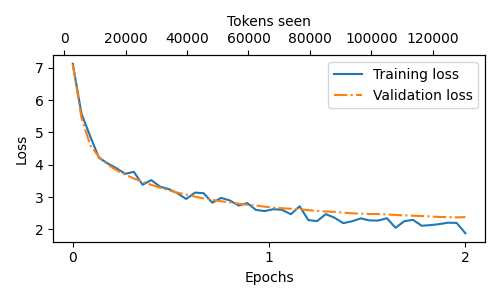

plot: py.Module = <module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/site-packages/matplotlib/pyplot.py'>
ticker: py.Module = <module 'matplotlib.ticker' from '/usr/local/lib/python3.12/site-packages/matplotlib/ticker.py'>

In [39]:
val plot = py.module("matplotlib.pyplot")
val ticker = py.module("matplotlib.ticker")

try {
  type Figure = py.Dynamic
  type Axis = py.Dynamic
    
  val (tokensSeen, trainingLoss, validationLoss) = trainingSteps.map {
    case TrainingStep(Loss(trainingLoss, validationLoss), tokensSeen) => (tokensSeen, trainingLoss, validationLoss)
  }.unzip3
  val epochs = torch.linspace(0, epochsCount, tokensSeen.length)
  val (figure, axis1) = plot.subplots(figsize = (5, 3)).as[(Figure, Axis)]
  axis1.plot(epochs, trainingLoss.toPythonProxy, label = "Training loss")
  axis1.plot(epochs, validationLoss.toPythonProxy, linestyle = "-.", label = "Validation loss")
  axis1.set_xlabel("Epochs")
  axis1.set_ylabel("Loss")
  axis1.legend(loc = "upper right")
  axis1.xaxis.set_major_locator(ticker.MaxNLocator(integer = true))
  val axis2 = axis1.twiny()
  axis2.plot(tokensSeen.toPythonProxy, trainingLoss.toPythonProxy, alpha = 0)
  axis2.set_xlabel("Tokens seen")
  figure.tight_layout()
  DisplaySupport.showPlot(plot)
} catch {
  case e: py.PythonException =>
    println("(!) If the exception below says 'Numpy is not available', restart the Jupyter kernel. It's an issue with Matplotlib in Jupyter.\n")
    throw e
}

In [40]:
val modelStateKey = "model"
val optimizerStateKey = "optimizer"
val statesMap = py"{$modelStateKey: ${model.state_dict()}, $optimizerStateKey: ${optimizer.state_dict()}}"
torch.save(statesMap, "model_and_optimizer.pth")

modelStateKey: String = "model"
optimizerStateKey: String = "optimizer"
statesMap: py.Dynamic = {'model': OrderedDict({'tokenEmbeddingLayer.weight': tensor([[ 1.7467e+00,  1.6750e+00,  2.4550e-01,  ...,  8.2859e-01,
         -2.2970e-01,  1.4564e+00],
        [-4.4679e-01,  1.1839e+00,  1.0902e+00,  ..., -7.5460e-01,
          4.2087e-01,  5.8719e-01],
        [ 1.5945e+00, -1.2873e+00, -3.3599e-03,  ...,  1.5097e+00,
         -1.7991e-01,  1.5387e-01],
        ...,
        [-1.1012e+00,  3.5025e-01, -1.9819e-01,  ...,  1.4751e+00,
         -6.8413e-01, -9.2930e-01],
        [-1.2830e+00,  1.1319e+00, -1.5019e+00,  ..., -1.1252e+00,
         -6.7377e-01, -8.8464e-01],
        [-1.0690e-01, -7.7091e-01,  1.5382e-01,  ...,  1.2587e-01,
          8.4397e-04,  9.9906e-01]]), 'positionEmbeddingLayer.weight': tensor([[ 2.8500e+00,  9.4432e-02, -6.4361e-01,  ..., -6.8505e-02,
          1.3166e+00, -6.2983e-01],
        [ 1.4499e+00,  5.0159e-01,  1.0971e+00,  ..., -2.2200e-01,
          2.451